In [4]:
import pandas as pd
import io
import base64
from PIL import Image
import matplotlib.pyplot as plt
import io
from PIL import Image
from IPython.display import display
from typing import Optional
import os

In [5]:
df = pd.read_pickle("data/phenology_df.pkl")

In [6]:

def plot_image(image_data):
    import io
    from PIL import Image


    # Create a BytesIO object from the binary data
    image_stream = io.BytesIO(image_data)

    # Open and show the image
    try:
        # Open the image using PIL
        img = Image.open(image_stream)
        
        # Save the image to a file
        img.save('output_image.png')
        
        # Display the image (this will open it in your default image viewer)
        img.show()
    except Exception as e:
        print(f"Error processing image: {e}")

def display_image(image_data):


    # Create BytesIO object from the binary data
    image_stream = io.BytesIO(image_data)
    img = Image.open(image_stream)

    # Display directly in the notebook
    display(img)


def display_images(image_datas, text: Optional[str] = None):
    # Display multiple images
    if not text:
        text = [""] * len(image_datas)
    for image_data, text in zip(image_datas, text):
        # Create BytesIO object from the binary data
        image_stream = io.BytesIO(image_data)
        img = Image.open(image_stream)
        # Display directly in the notebook
        print(text)
        display(img)

def get_pil_image(image_bytes):
    image_stream = io.BytesIO(image_bytes)
    return Image.open(image_stream)

In [7]:
# TODO cols to look at: location_image, county_image, position_image, percentage_of_unripe_wheat_image (some have perceentage)

In [ ]:
# TODO remove after look into converted dataset

"""
NOTE 
Finetune qwen to extract phenology data
"""
# !pip install unsloth
from qwen_helper_funcs import inference
from constants import SYSTEM_PROMPT
import pandas as pd
import numpy as np
from tqdm import tqdm
from helper_funcs import display_image
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
from datetime import datetime
from prepare_data_qwen import prepare_dataset, make_labelled_df
# from PIL import Image as PILImage
from constants import SYSTEM_PROMPT
import pandas as pd
# NOTE the 7 always consists of a horizontal line

DATASET_PATH = "data/df_labelled_all.pkl" 



train_columns = [
    "coltsfoot_flowering",
    "coltsfoot_fruit",
    "wheat_maturing_time",
    "sowtime_wheat",
    "sowtime_barley",
    "liverleaf_fruit",
    "wood_anemone_flowering",
    "oats_maturing_time",
    "barley_maturing_time",
    "wheat_ripe_for_harvesting",
    "meadowsweet_timespan",
    "heather_flowering",
    "heather_timespan",
    "hazel_greenup",
    "hazel_greenup_timespan",
    "hazel_flowering",
    "hazel_start_ripening",
    "hazel_flowering_timespan",
    "hazel_start_senescence",
    "hazel_start_leaffall",
    "hazel_end_leaffall", 
    "grey_alder_greenup", 
    "grey_alder_greenup_timespan",
    "grey_alder_flowering", 
    "grey_alder_start_ripening", 
    "grey_alder_flowering_timespan", 
    "grey_alder_start_senescence"
]

all_columns = train_columns 
make_labelled_df(all_columns)


df = pd.read_pickle(DATASET_PATH)


# df[train_columns[4] + "_image"].tolist()[:3]


### Normal labeling

In [9]:
COLUMN = "average_height_where_leafout_at_the_treeline_is_measured"

In [10]:
df = pd.read_pickle("data/phenology_df.pkl")

In [11]:
a = df[COLUMN].values



In [ ]:
labels_path = f"labels/label_{COLUMN}.txt"
if os.path.exists(labels_path):
    print(f"Path {labels_path} exists")
else:
    with open(labels_path, "w") as f:
        for value in df[COLUMN].values:
            f.write(value + "\n")

In [13]:
idx = 0
batch_size = 10

In [14]:
# idx-=20
# idx = 230

In [ ]:
a, b = df[COLUMN].values[idx], df[f"{COLUMN}_image"].values[idx:idx+batch_size]
texts = [f"line {i+1}" for i in range(idx, idx+batch_size)]
display_images(b, texts)
# print("IDX", idx)
idx += batch_size

### Grouping

In [19]:
# NOTE lookin at blank labels (and their image)
# first load all images we have labels for


In [20]:
train_columns = [
    "coltsfoot_flowering",
    "coltsfoot_fruit",
    "wheat_maturing_time",
    "sowtime_wheat",
    "sowtime_barley",
    "liverleaf_fruit",
    "wood_anemone_flowering",
    "oats_maturing_time",
    "barley_maturing_time",
    "wheat_ripe_for_harvesting",
    "meadowsweet_timespan",
    "heather_flowering",
    "heather_timespan",
    "hazel_greenup",
    "hazel_greenup_timespan",
    "hazel_flowering",
    "hazel_start_ripening",
    "hazel_flowering_timespan",
    "hazel_start_senescence",
    "hazel_start_leaffall",
    "hazel_end_leaffall", 
    "grey_alder_greenup", 
    "grey_alder_greenup_timespan"
]

test_columns = [
    "grey_alder_flowering", 
    "grey_alder_start_ripening", 
    "grey_alder_flowering_timespan", 
    "grey_alder_start_senescence"
]

In [ ]:
all_columns = train_columns + test_columns

In [21]:
df_labelled = pd.read_pickle("data/df_labelled_all.pkl")

In [22]:
image_and_label_columns = [(col + "_image", col + "_labels") for col in all_columns]

In [23]:
all_images = []
all_labels = []
for img_col, label_col in image_and_label_columns:
    all_images.extend(df_labelled[img_col].tolist())
    all_labels.extend(df_labelled[label_col].tolist())

In [247]:
# TODO here you can select which group of labels you want to look at

# blank labels
relevant_indices = [i for i, label in enumerate(all_labels) if label == "" or label == "%"]

# brackets
# relevant_indices = [i for i, label in enumerate(all_labels) if "[" in label or "]" in label]

# parenthesis
# relevant_indices = [i for i, label in enumerate(all_labels) if "(" in label or ")" in label]

# where first digit is 7
# import re
# where first digit is 7
# relevant_indices = [i for i, label in enumerate(all_labels) if label and re.match(r'^7\d+', label)]

# where 7 is the last digit
# relevant_indices = [i for i, label in enumerate(all_labels) if label and re.match(r'.*7$', label)]

# where 7 is the middle digit (has digits before and after)
# relevant_indices = [i for i, label in enumerate(all_labels) if label and re.match(r'.*\d+7\d+.*', label)]


# where string only consists of 1 number (but any number of other chars)
# relevant_indices = [i for i, label in enumerate(all_labels) if label and len(re.findall(r'\d', label)) == 1]


# # Find indices where the label contains a number greater than 300
# relevant_indices = []
# for i, label in enumerate(all_labels):
#     # Extract all numbers from the label
#     if label:
#         numbers = re.findall(r'\d+', label)
#         # Check if any number is greater than 300
#         for num in numbers:
#             if int(num) > 365:
#                 relevant_indices.append(i)
#                 break


# relevant_indices = [i for i, label in enumerate(all_labels) if "7" in label] 

In [ ]:
relevant_images = [all_images[i] for i in relevant_indices]
relevant_labels = [all_labels[i] for i in relevant_indices]
print(len(relevant_images))

In [280]:
relevant_idx_to_all_idx = {i: relevant_indices[i] for i in range(len(relevant_indices))}

In [299]:
idx = 0
batch_size = 3

label: [79] line 19, 


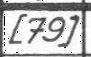

label: [114] line 20, 


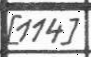

label: [134] line 21, 


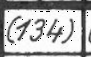

In [307]:
images = relevant_images[idx:idx+batch_size]
labels = relevant_labels[idx:idx+batch_size]
texts = [f"label: {relevant_labels[i]} line {i+1}, " for i in range(idx, idx+batch_size)]
idx += batch_size
display_images(images, texts)

In [ ]:
# NOTE select ines from iterating through above, this piece of code will tell you which file and line to look at to fix the label
lines_to_check = [
    12
]
indices_to_check = [i-1 for i in lines_to_check]
# indices_to_check = [
#                     95, 97, 186, 193, 
#                     209, 268,
#                     320,331,335,339,340,343,354,356,358,362,364,370,
#                     372,381,398,432,439,440,468,471,472,480,486] # NOTE this is idx in relevant_...

for idx in indices_to_check:
    all_idx = relevant_idx_to_all_idx[idx]
    display_image(all_images[all_idx])
    print("GT: ", all_labels[all_idx])
    file_index = all_idx//278
    print(all_columns[file_index])
    print("LINE: ", (all_idx%278)+1)

    print("\n---\n")

In [ ]:
len(all_images)

In [ ]:
# NOTE look at converted testset

In [ ]:
"""
NOTE 
Finetune qwen to extract phenology data
"""
# !pip install unsloth
from qwen_helper_funcs import inference
from constants import SYSTEM_PROMPT
import pandas as pd
import numpy as np
from tqdm import tqdm
from helper_funcs import display_image
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
from datetime import datetime
from prepare_data_qwen import prepare_dataset, make_labelled_df
# from PIL import Image as PILImage
from constants import SYSTEM_PROMPT
import pandas as pd
# NOTE the 7 always consists of a horizontal line

# DATASET_PATH = "data/df_labelled_090425v2.pkl" # TODO update this
# DATASET_PATH = "data/df_labelled_090425v3.pkl" 
# DATASET_PATH = "data/df_labelled_090425v4.pkl" 
DATASET_PATH = "data/df_labelled_all.pkl" 



train_columns = [
    "coltsfoot_flowering",
    "coltsfoot_fruit",
    "wheat_maturing_time",
    "sowtime_wheat",
    "sowtime_barley",
    "liverleaf_fruit",
    "wood_anemone_flowering",
    "oats_maturing_time",
]

test_columns = [
    "barley_maturing_time",
    "wheat_ripe_for_harvesting"
]



all_columns = train_columns + test_columns
make_labelled_df(all_columns)

converted_dataset = prepare_dataset(DATASET_PATH, SYSTEM_PROMPT, train_columns)
converted_dataset_test = prepare_dataset(DATASET_PATH, SYSTEM_PROMPT, test_columns, 1)


In [2]:
idx = 0
batch_size = 5

In [ ]:
for i in range(idx, idx+batch_size):
    image = converted_dataset[i]["messages"][0]["content"][1]["image"]
    text = converted_dataset[i]["messages"][1]["content"][0]["text"]
    print(text)
    image.show()
    print("---")
idx += batch_size


In [ ]:

image.show()

In [59]:
prompt = """
        In the image you should see three numbers. Degrees north, degrees east, H and K. 
        Extract the four numbers and return a dictionary with the keys 'N' (north), 'E' (east), 'H', 'K'. Example output:  '{'N': 59.2, 'E': 10.2, 'H': 10, 'K': 10}
        Return ONLY the dictionary, nothing else.
        """

In [60]:
from qwen_inference import predict

In [65]:
def parse_output(output: str) -> dict:
    # Extract the dictionary string from the markdown code block
    dict_str = output.split("\n")[1].strip()
    # Remove any markdown code block formatting
    dict_str = dict_str.replace("```python\n", "").replace("\n```", "")
    # Parse the dictionary string into a Python dict
    return eval(dict_str)

In [113]:
idx_to_pred = {}

In [ ]:

for idx, image_bytes in enumerate(df["position_image"].values):
    image = get_pil_image(image_bytes)
    if idx < 154:
        continue
    if idx in idx_to_pred:
        print(f"Skipping {idx} because it already has a prediction")
        continue
    print(f"Predicting {idx}")
    pred = predict(image, prompt)
    idx_to_pred[idx] = pred



In [ ]:
for idx in range(0, 154):
    output = idx_to_pred[idx]
    print(parse_output(output))

In [110]:
# save preds to file
import json
with open("preds_location.json", "w") as f:
    json.dump(idx_to_pred, f, indent=4)

In [111]:
# write to file
with open(f"labels/label_position_new", "w") as f:
    for idx in range(len(idx_to_pred)):
        output = idx_to_pred[idx]
        parsed_output = parse_output(output)
        f.write(str(parsed_output))
        f.write("\n")


In [135]:
idx = 20

In [ ]:
# fix pred errors by going through samples

a, b = df[COLUMN].values[idx], df[f"{COLUMN}_image"].values[idx:idx+batch_size]
texts = [f"line {i+1}" for i in range(idx, idx+batch_size)]
display_images(b, texts)
# print("IDX", idx)
idx += batch_size

## Check accuracy

In [174]:
labels = ["unknown" if label == "" else label for label in labels]

In [ ]:
num_correct, num_preds = 0, 0
for idx, (pred, label) in enumerate(zip(preds, labels)):
    num_preds += 1
    if pred == label:
        num_correct += 1
    else:
        print(idx, pred, label)

print(f"Accuracy: {num_correct / num_preds}")


In [ ]:
print("PRED:  '(107)'")
print("LABEL: '107'")
display_image(df["coltsfoot_flowering_image"].values[97])


In [ ]:
preds = df["coltsfoot_flowering"].values
preds

In [ ]:
# coltsfoot_flowering', 'coltsfoot_flowering_image', 'coltsfoot_fruit', 'coltsfoot_fruit_image', 'coltsfoot_timespan', 'coltsfoot_timespan_image', 